# Project for WikiShop

Wikishop online store launches a new service. Now users can edit and supplement product descriptions like in wiki communities. That is, customers offer their edits and comment on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation. 

Train the model to categorize comments into positive and negative. You have a dataset with markup on the toxicity of edits.

We will evaluate the model as successful if the quality metric value *F1* will be at least 0.75. 

**Description of data**

The data is in the file `toxic_comments.csv`. The *text* column in it contains the text of the comment, and *toxic* contains the target attribute.

Work plan:
1. Study the general information from the dataframe.
2. Check the balance of the classes.
3. Perform lemmatization of the text.
4. Create a TF-IDF matrix.
5. Build several models and find the value of F1 metric for them on the training sample.
6. Check the quality of the best models on the test sample.

<a id="0"></a> <br>
# Table of Contents  
1. [Preparation](#1)     
2. [Training](#2)
3. [Conclusion](#3)

<a id="1"></a>
## Preparation
[Back to the top](#0)

In [2]:
#pip install nb_black

In [21]:
#%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd

import numpy as np

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline

from nltk.probability import FreqDist

from catboost import CatBoostClassifier

import lightgbm as lgb

import spacy

Load the data.

In [2]:
df = pd.read_csv("toxic_comments.csv", sep=",", index_col=[0])
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [10]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<IPython.core.display.Javascript object>

We see that there are upper case words in the texts, let's bring them to lower case for better performance of future models.

In [16]:
df["text"] = df["text"].str.lower()

<IPython.core.display.Javascript object>

In [17]:
df.head(10)

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0
5,"""\n\ncongratulations from me as well, use the ...",0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<IPython.core.display.Javascript object>

Get the lemmatized text in a new column `lemm_text`.

In [17]:
nlp = spacy.load("en_core_web_sm")

In [21]:
%%time
df['lemm_text'] = df['text'].apply(lambda text: " ".join(token.lemma_ for token in nlp(text) if not (token.is_stop 
                                                                                                     or token.is_punct
                                                                                                    or token.like_num)))

Wall time: 39min 58s


<IPython.core.display.Javascript object>

In [22]:
df.head()

,text,toxic,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation \n edit username hardcore metallic...
1,d'aww! he matches this background colour i'm s...,0,d'aww match background colour seemingly stick ...
2,"hey man, i'm really not trying to edit war. it...",0,hey man try edit war guy constantly remove rel...
3,"""\nmore\ni can't make any real suggestions on ...",0,\n \n real suggestion improvement wonder secti...
4,"you, sir, are my hero. any chance you remember...",0,sir hero chance remember page


<IPython.core.display.Javascript object>

In [23]:
df.to_csv(r"df_processed_11.csv", index=False, sep=",")

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_csv("df_processed_11.csv", sep=",")
df.head(10)

,text,toxic,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation \n edit username hardcore metallic...
1,d'aww! he matches this background colour i'm s...,0,d'aww match background colour seemingly stick ...
2,"hey man, i'm really not trying to edit war. it...",0,hey man try edit war guy constantly remove rel...
3,"""\nmore\ni can't make any real suggestions on ...",0,\n \n real suggestion improvement wonder secti...
4,"you, sir, are my hero. any chance you remember...",0,sir hero chance remember page
5,"""\n\ncongratulations from me as well, use the ...",0,\n\n congratulation use tool talk
6,cocksucker before you piss around on my work,1,cocksucker piss work
7,your vandalism to the matt shirvington article...,0,vandalism matt shirvington article revert ban
8,sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive intend write art...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


In [3]:
df[df["lemm_text"].isna()]

,text,toxic,lemm_text
627,seems we both have some.,0,NaN
2400,"here, here and here.",0,NaN
8583,what is it that you can do as well as others? ...,0,NaN
8824,what is i 78.146.102.144,0,NaN
10068,i might as well give up then.,0,NaN
...,...,...,...
151541,something must be done!,0,NaN
152543,same for this 166.137.240.20,0,NaN
153041,which is over 9000 over 9000 over 9000 over 90...,0,NaN
155467,"if you have more to say, put",0,NaN


We see that there are rows with empty values in the `lemm_text` column, they are few, so we can ignore them when building models.

In [4]:
df.dropna(inplace=True)

In [5]:
df.isna().sum()

text         0
toxic        0
lemm_text    0
dtype: int64

Find the most frequently occurring words in the texts.

In [6]:
fdist = FreqDist(df["lemm_text"])

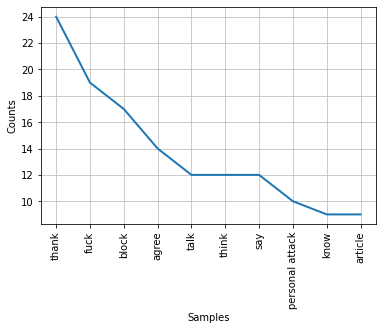

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [7]:
fdist.plot(10, cumulative=False)

We see that verbs occur most often. It is also worth noting that there are no punctuation marks, numbers, and service words in the graph, which indicates that the text processing is correct.

We split the source data into two samples: training(80%) and test(20%).

In [8]:
RANDOM_STATE = 12345

In [9]:
target = df["toxic"]
features = df["lemm_text"]
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target
)

The resulting samples have the following sizes:

In [10]:
features_train.shape

(127356,)

In [11]:
features_test.shape

(31840,)

We can see by the number of rows in each sample that the separation has been done correctly.

Have a look at the relative frequencies of the classes in the target feature `toxic'.

In [12]:
class_frequency = df["toxic"].value_counts(normalize=True)
class_frequency

0    0.898333
1    0.101667
Name: toxic, dtype: float64

<AxesSubplot:>

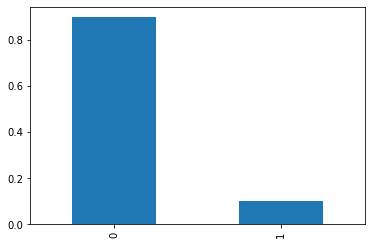

In [13]:
class_frequency.plot(kind="bar")

We can see that there is an imbalance of classes in the target feature.

In [14]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [114408  12948]
Количество строк в target_test по классам: [28603  3237]


We see that the class imbalance in `toxic' remains the same in the samples obtained.

Next, we will use class weighting in model building, i.e. we will give objects of a rare class a higher weight.

Create a corpuses of texts for training and test samples.

In [15]:
corpus_train = features_train.values
corpus_test = features_test.values

Create a matrix with the TF-IDF values of the obtained corpuses.

In [18]:
stopwords = nlp.Defaults.stop_words

<a id="2"></a>
## Training
[Back to the top](#0)

Build several models to predict the values of the target attribute `toxic`.

Examine the logistic regression model.

In [43]:
pipeline_lr = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=stopwords)),
        ("tfidf", TfidfTransformer()),
        ("lr", LogisticRegression(random_state=RANDOM_STATE, solver="liblinear"),),
    ]
)

<IPython.core.display.Javascript object>

In [45]:
parameters_lr = {"vect__ngram_range": ((1, 1), (1, 2)), "lr__C": (1.5, 2.5)}

<IPython.core.display.Javascript object>

In [46]:
%%time
grid_lr = GridSearchCV(pipeline_lr, parameters_lr, scoring="f1", cv=5, n_jobs=-1)
grid_lr.fit(corpus_train, target_train)
grid_lr.best_params_

C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 2min 41s


{'lr__C': 2.5, 'vect__ngram_range': (1, 1)}

<IPython.core.display.Javascript object>

In [47]:
print(
    "f1 модели линейной регрессии на обучающей выборке:", grid_lr.best_score_,
)

f1 модели линейной регрессии на обучающей выборке: 0.7624890828199182


<IPython.core.display.Javascript object>

Now let's consider the decision tree.

In [48]:
pipeline_tr = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=stopwords)),
        ("tfidf", TfidfTransformer()),
        ("tr", DecisionTreeClassifier(random_state=RANDOM_STATE),),
    ]
)

<IPython.core.display.Javascript object>

In [49]:
parameters_tr = {
    "vect__ngram_range": ((1, 1), (1, 2)),
    "tr__max_depth": range(1, 10, 1),
}

<IPython.core.display.Javascript object>

In [50]:
%%time
grid_tr = GridSearchCV(pipeline_tr, parameters_tr, scoring="f1", cv=5, n_jobs=-1)
grid_tr.fit(corpus_train, target_train)
grid_tr.best_params_

C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 12min 14s


{'tr__max_depth': 9, 'vect__ngram_range': (1, 2)}

<IPython.core.display.Javascript object>

In [51]:
print(
    "f1 модели дерева решений на обучающей выборке:", grid_tr.best_score_,
)

f1 модели дерева решений на обучающей выборке: 0.5984427749050161


<IPython.core.display.Javascript object>

Build a model of the random forest.

In [52]:
pipeline_rf = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=stopwords)),
        ("tfidf", TfidfTransformer()),
        ("rf", RandomForestClassifier(random_state=RANDOM_STATE)),
    ]
)

<IPython.core.display.Javascript object>

In [53]:
parameters_rf = {
    "vect__ngram_range": ((1, 1), (1, 2)),
    "rf__n_estimators": range(10, 31, 5),
}

<IPython.core.display.Javascript object>

In [54]:
%%time
grid_rf = GridSearchCV(pipeline_rf, parameters_rf, scoring="f1", cv=3)
grid_rf.fit(corpus_train, target_train)
grid_rf.best_params_

C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be incon

Wall time: 2h 33min 55s


{'rf__n_estimators': 25, 'vect__ngram_range': (1, 1)}

<IPython.core.display.Javascript object>

In [55]:
print(
    "f1 модели случайного леса на обучающей выборке:", grid_rf.best_score_,
)

f1 модели случайного леса на обучающей выборке: 0.7172610034737178


<IPython.core.display.Javascript object>

Next, we will build a gradient boosting model using the CatBoost and LightGBM libraries.

In [67]:
pipeline_CBR = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=stopwords)),
        ("tfidf", TfidfTransformer()),
        (
            "CBR",
            CatBoostClassifier(
                random_state=RANDOM_STATE,
                loss_function="Logloss",
                eval_metric="TotalF1",
                verbose=250,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [70]:
parameters_CBR = {
    "CBR__depth": [3, 4],
    "CBR__learning_rate": [0.3, 0.5],
    "CBR__iterations": [500],
}

<IPython.core.display.Javascript object>

In [71]:
%%time
grid_CBR = GridSearchCV(pipeline_CBR, parameters_CBR, scoring="f1", cv=3)
grid_CBR.fit(corpus_train, target_train)
grid_CBR.best_params_

C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.9005317	total: 252ms	remaining: 2m 5s
250:	learn: 0.9545587	total: 1m 40s	remaining: 1m 39s
499:	learn: 0.9601336	total: 3m 58s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.8974554	total: 386ms	remaining: 3m 12s
250:	learn: 0.9555858	total: 2m 6s	remaining: 2m 5s
499:	learn: 0.9617632	total: 3m 55s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.8949568	total: 374ms	remaining: 3m 6s
250:	learn: 0.9557340	total: 2m 3s	remaining: 2m 2s
499:	learn: 0.9612428	total: 3m 56s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.9005317	total: 364ms	remaining: 3m 1s
250:	learn: 0.9597721	total: 2m 2s	remaining: 2m 1s
499:	learn: 0.9667704	total: 3m 54s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.8974554	total: 1.48s	remaining: 12m 18s
250:	learn: 0.9610128	total: 1m 59s	remaining: 1m 58s
499:	learn: 0.9670856	total: 3m 51s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.8949568	total: 355ms	remaining: 2m 57s
250:	learn: 0.9607363	total: 1m 59s	remaining: 1m 58s
499:	learn: 0.9673826	total: 3m 50s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.9005412	total: 536ms	remaining: 4m 27s
250:	learn: 0.9569901	total: 2m 47s	remaining: 2m 45s
499:	learn: 0.9644541	total: 5m 14s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.8974554	total: 470ms	remaining: 3m 54s
250:	learn: 0.9579315	total: 2m 38s	remaining: 2m 36s
499:	learn: 0.9654606	total: 5m 14s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.9061052	total: 510ms	remaining: 4m 14s
250:	learn: 0.9580413	total: 2m 41s	remaining: 2m 40s
499:	learn: 0.9649598	total: 5m 19s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.9005412	total: 476ms	remaining: 3m 57s
250:	learn: 0.9639298	total: 2m 35s	remaining: 2m 34s
499:	learn: 0.9681408	total: 5m 9s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.8974554	total: 547ms	remaining: 4m 32s
250:	learn: 0.9648217	total: 2m 34s	remaining: 2m 33s
499:	learn: 0.9683831	total: 5m 18s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.9061052	total: 511ms	remaining: 4m 14s
250:	learn: 0.9641782	total: 2m 46s	remaining: 2m 44s
499:	learn: 0.9685349	total: 5m 27s	remaining: 0us


C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0:	learn: 0.8971960	total: 610ms	remaining: 5m 4s
250:	learn: 0.9597867	total: 2m 24s	remaining: 2m 23s
499:	learn: 0.9653721	total: 4m 44s	remaining: 0us
Wall time: 1h 3min 42s


{'CBR__depth': 3, 'CBR__iterations': 500, 'CBR__learning_rate': 0.5}

<IPython.core.display.Javascript object>

In [72]:
print(
    "f1 модели CatBoostClassifier на обучающей выборке:", grid_CBR.best_score_,
)

f1 модели CatBoostClassifier на обучающей выборке: 0.7578957744512946


<IPython.core.display.Javascript object>

In [75]:
pipeline_lgb = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=stopwords)),
        ("tfidf", TfidfTransformer()),
        ("lgb", lgb.LGBMClassifier(verbosity=-1)),
    ]
)

<IPython.core.display.Javascript object>

In [74]:
parameters_lgb = {
    "vect__ngram_range": ((1, 1), (1, 2)),
    "lgb__max_depth": [3, 4],
    "lgb__learning_rate": [0.3, 0.5],
    "lgb__n_estimators": [500],
}

<IPython.core.display.Javascript object>

In [76]:
%%time
grid_lgb = GridSearchCV(pipeline_lgb, parameters_lgb, scoring="f1", cv=3)
grid_lgb.fit(corpus_train, target_train)
grid_lgb.best_params_

C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Users\Sereb\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be incon

Wall time: 21min 4s


{'lgb__learning_rate': 0.3,
 'lgb__max_depth': 3,
 'lgb__n_estimators': 500,
 'vect__ngram_range': (1, 2)}

<IPython.core.display.Javascript object>

In [77]:
print(
    "f1 модели LGBMRegressor на обучающей выборке:", grid_lgb.best_score_,
)

f1 модели LGBMRegressor на обучающей выборке: 0.7718777660732652


<IPython.core.display.Javascript object>

<a id="3"></a>
## Conclusion
[Back to the top](#0)

From the obtained values of the f1 metric for different models, it is evident that the LGBMRegressor gradient-boosting model showed the best result. Let's check its quality on the test sample.

In [79]:
pred = grid_lgb.best_estimator_.predict(corpus_test)
f1_score(pred, target_test)

0.7730605285592498

<IPython.core.display.Javascript object>

We see that the LGBMClassifier model shows close values of the f1 metric on the training and test samples. The desired accuracy of the model on the test sample has been achieved (f1=0.77 > 0.75).

In this project, the following models were built and trained on a markup dataset of comment toxicity using the TF-IDF matrix: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier, and LGBMClassifier. These were used to make predictions about the tonality of the comments. Based on the F1 metric values, the one with the best prediction quality was selected. It was the gradient boosting model LGBMClassifier with F1 value equal to 0.77.